## Spin-Down Analysis for Calibration of Tick Positions

This code executes 400 simultaneous fits (for each of the 400 tick positions) to *encoder count vs time* data acquired during a free decay. The 400 fits are constrained to follow the same polynomial time dependence, with an independent offset for each of the tick positions. 

See "SR542 SpinDown BrassFlywheel 2" for an explanation of the linear algebra used to perform the simultaneous fitting

In [54]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from glob import glob
import os

In [2]:
file_dir = Path('.\CalData')

In [4]:
f = open(file_dir/'encoderCal_20460001_vert_0.txt', 'r')
sn = f.readline()
shaftIndex = f.readline()
rotorOffset = f.readline()
f.close()

In [5]:
sn[0]

'#'

In [6]:
def DoSpinDownCal(fname, rotorOffset = 0):
    ftm_freq = 60e6
    N_enc = int(400)
    
    f = open(fname, "r")
    sn = f.readline()
    if sn[0] == '#':
        shaftIndex = f.readline()
        rotorOffset = f.readline()
        sn = sn.strip('# sn = ').strip()
        print(f'Chopper Head serial number: {sn}')
        rotorOffset = int(rotorOffset.strip('# rotor offset = ').strip())
    
    f.close()
    
    print(f'rotor offset = {rotorOffset}')
    
    headerRows = 4
    revsToSkip = 4
    rowsToSkip = revsToSkip*N_enc + headerRows
    rowsToImport = N_enc*((14648 - rowsToSkip)//N_enc)
    N_revs = int(rowsToImport/N_enc)
    print(f'Importing {rowsToImport} rows ({N_revs} revs worth of data)')
    
    # Assumes raw data contains 3 columns: raw count, ftm input captures of edges, (ignore column 3)
    df = pd.read_csv(fname, sep=',', skiprows=rowsToSkip, nrows = rowsToImport, 
                 index_col=False, comment='#', names=['count', 'input cap', 'phase'])        
    
    # Convert raw encoder counts to unwrapped encoder count 
    count = df['count'].to_numpy()
    missedOrExtraCounts = np.where(np.mod(np.diff(count), 400) != 1)[0]
    if missedOrExtraCounts.size > 0:
        print(f'Found missing or extra counts at: {missedOrExtraCounts}')
        return
    else:
        print("No missing or extra counts")
        
    rotorAngle = np.array((count + rotorOffset)%N_enc, dtype='int')
    uwRotorAngle = np.arange(0, rowsToImport, 1)    
    # Note that uwRotorAngle[0] = 0 (which is != rotorAngle[0])
    # This makes building the matrices easier, but later we must utilize rotorAngle[0] to map
    # the corrections to the specific rotor orientation
    
    # Convert ftm input capture counts to unwrapped time in seconds
    captures = df['input cap'].to_numpy()            
    captureDiffs = np.mod(np.diff(captures, prepend=0), 65536)
    t_s = (np.cumsum(captureDiffs) - captureDiffs[0])/ftm_freq  
    
    # We want to solve the matrix equation Y = B*X for optimum fit parameters B, where
    # Y = [rotorAngle[0], rotorAngle[1], ... rotorAngle[rowsToImport - 1]], of size (rowsToImport x 1 array)
    # B = [c_00, c_01, c_02, ... c_0399, c_1, c_2, c_3, c_4, c_5], of size ((N_enc + 5) x 1 array) for a 5-th order poly fit
    # X = [1, 0, 0, ... t_0, t_0^2, t_0^3, t_0^4, t_0^5], of size (rowsToImport x (N_enc + 5) array)

    fitOrder = 5
    X = np.zeros((rowsToImport, N_enc + fitOrder))
    for revNum in range(0, N_revs):
        X[revNum*N_enc:(revNum+1)*N_enc, 0:N_enc] = np.identity(N_enc)
    for powerOf_t in range(1, fitOrder+1):
        X[:, (N_enc-1) + powerOf_t] = t_s**powerOf_t
        
    Xtrans = np.transpose(X)
    Y = uwRotorAngle
    # This is the entire regression analysis in one line!!! B = ((X^T * X)^-1 * X^T) * Y
    B = np.matmul(np.matmul(np.linalg.inv(np.matmul(Xtrans, X)), Xtrans), Y)
    # The tick offsets c_00, c_01, .. c0399 are the first 400 elements of B
    tickOffsets = B[0:N_enc]       
    fig1, ax1 = plt.subplots()
    ax1.plot(rotorAngle[0:N_enc], -tickOffsets)
    ax1.set_xlabel('rotor angle (ticks)')
    ax1.set_ylabel('tick offset (ticks)')
    ax1.set_title('Best Fit tick offsets')
    # This is where we make sure to map the tickOffsets to the proper rotor orientation
    calibratedTickPositions = np.arange(0, N_enc, 1) - np.roll(tickOffsets, int(rotorAngle[0]))
    calibratedTickPositions -= calibratedTickPositions[0]
    
    # Check the calibration
    fitCoeffs = np.insert(B[N_enc:], 0, 0.0)
    fit = np.poly1d(np.flip(fitCoeffs))
    
    correctedRotorAngle_ticks = calibratedTickPositions[rotorAngle]
    print(rotorAngle)
    print(correctedRotorAngle_ticks)
    
    correctedRotorAngle_rad = correctedRotorAngle_ticks/N_enc*2*np.pi
    uwCorrRotorAngle_rad = np.unwrap(correctedRotorAngle_rad)
    uwCorrRotorAngle_ticks = uwCorrRotorAngle_rad*N_enc/(2*np.pi)
    
    fig2, ax2 = plt.subplots()
    #ax2.plot(t_s, uwRotorAngle - fit(t_s), 'o')
    ax2.plot(t_s, uwCorrRotorAngle_ticks - uwCorrRotorAngle_ticks[0] - fit(t_s))
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('residual (correctedTick - fit) (ticks)')
    ax2.set_title('Calibration Verification')
    
    # Residual error after application of calibration
    rms_tickError_uncal = np.std(uwRotorAngle - fit(t_s))
    rms_tickError_calibrated = np.std(uwCorrRotorAngle_ticks - uwCorrRotorAngle_ticks[0] - fit(t_s))
    print(f'The RMS tick error of the uncalibrated tick positions is: {rms_tickError_uncal:.6f} ticks')
    print(f'The RMS tick error of the calibrated tick positions is: {rms_tickError_calibrated:.6f} ticks')
    
    return calibratedTickPositions

In [7]:
file_dir = Path('./CalData')

Chopper Head serial number: 20460001
rotor offset = 77
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[109 110 111 ... 106 107 108]
[108.94960867 109.99920709 110.94701314 ... 105.99815321 106.94625459
 107.93886495]
The RMS tick error of the uncalibrated tick positions is: 0.056586 ticks
The RMS tick error of the calibrated tick positions is: 0.000322 ticks


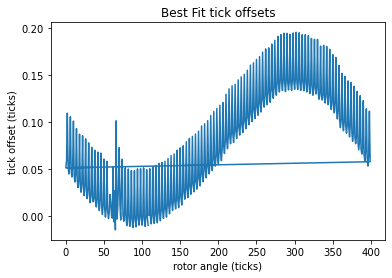

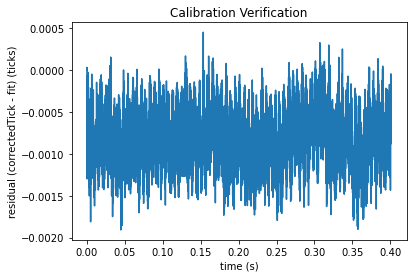

In [10]:
fname = 'encoderCal_20460001_horiz_0.txt'
calTicks_0 = DoSpinDownCal((file_dir/fname), 77)

In [56]:
np.savetxt(os.path.join('.\CalData', 'tickPos_20460001.csv'), calTicks_0/400, newline='\n', fmt='%.6e', delimiter=',')

Chopper Head serial number: 20460001
rotor offset = 54
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[168 169 170 ... 165 166 167]
[167.97453327 168.98598635 170.03619412 ... 164.98354445 166.03362959
 166.98223356]
The RMS tick error of the uncalibrated tick positions is: 0.056880 ticks
The RMS tick error of the calibrated tick positions is: 0.000351 ticks


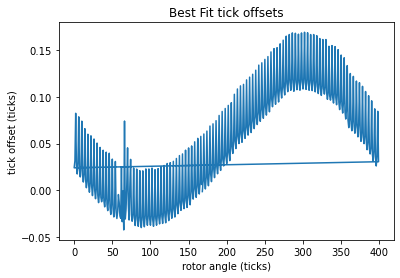

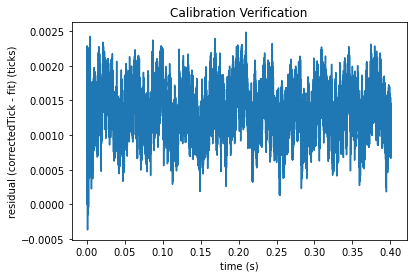

In [17]:
fname = 'encoderCal_20460001_horiz_16.txt'
calTicks_16 = DoSpinDownCal((file_dir/fname), 54)

Chopper Head serial number: 20460001
rotor offset = 90
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[333 334 335 ... 330 331 332]
[333.08011861 334.12930448 335.07642401 ... 330.136505   331.07931813
 332.0726566 ]
The RMS tick error of the uncalibrated tick positions is: 0.056475 ticks
The RMS tick error of the calibrated tick positions is: 0.000334 ticks


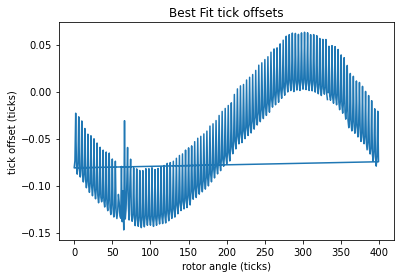

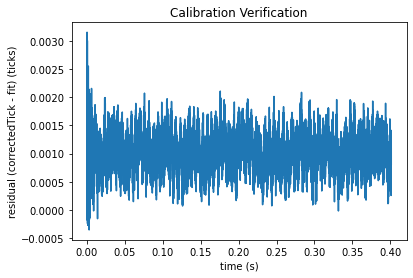

In [16]:
fname = 'encoderCal_20460001_horiz_17.txt'
calTicks_17 = DoSpinDownCal((file_dir/fname), 90)

Chopper Head serial number: 20460001
rotor offset = 363
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[112 113 114 ... 109 110 111]
[111.9488972  112.95910633 114.00956483 ... 108.9576308  110.00761695
 110.95524437]
The RMS tick error of the uncalibrated tick positions is: 0.054322 ticks
The RMS tick error of the calibrated tick positions is: 0.000416 ticks


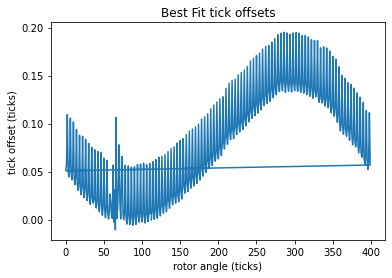

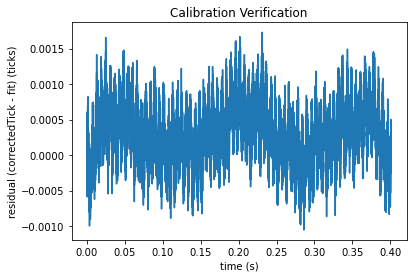

In [23]:
fname = 'encoderCal_20460001_vert_18.txt'
calTicks_18 = DoSpinDownCal((file_dir/fname), 90)

Chopper Head serial number: 20460001
rotor offset = 103
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[107 108 109 ... 104 105 106]
[106.95493541 107.94773944 108.95823532 ... 103.94639672 104.95720753
 106.00703322]
The RMS tick error of the uncalibrated tick positions is: 0.053704 ticks
The RMS tick error of the calibrated tick positions is: 0.000374 ticks


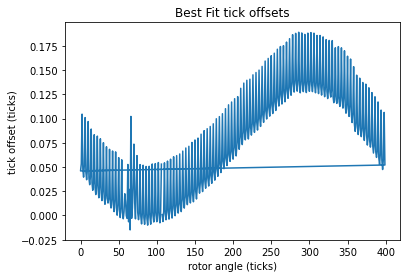

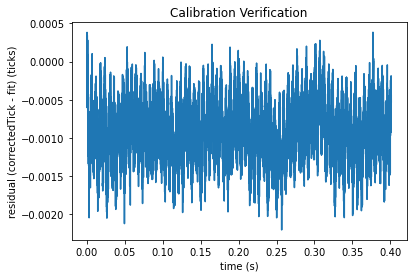

In [25]:
fname = 'encoderCal_20460001_vert_19.txt'
calTicks_19 = DoSpinDownCal((file_dir/fname), 90)

Chopper Head serial number: 20460001
rotor offset = 325
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[349 350 351 ... 346 347 348]
[349.06873237 350.11833873 351.06416315 ... 346.12378593 347.06704699
 348.05943208]
The RMS tick error of the uncalibrated tick positions is: 0.053517 ticks
The RMS tick error of the calibrated tick positions is: 0.000396 ticks


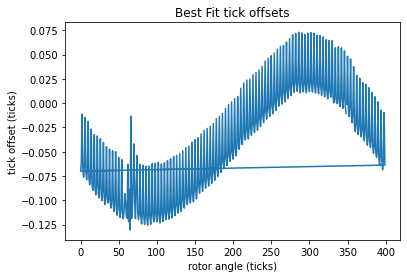

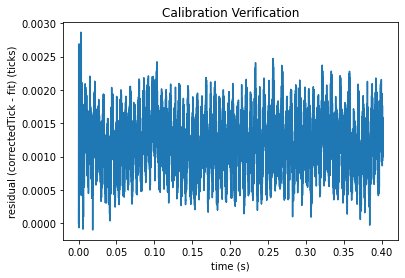

In [28]:
fname = 'encoderCal_20460001_vert_20.txt'
calTicks_20 = DoSpinDownCal((file_dir/fname), 90)

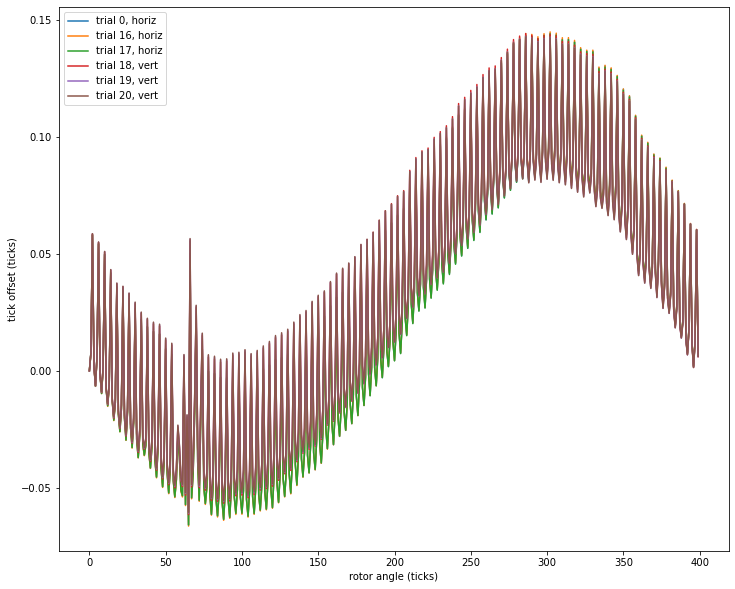

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
ax.plot(calTicks_0 - np.arange(0, 400, 1), label='trial 0, horiz')
ax.plot(calTicks_16 - np.arange(0, 400, 1), label='trial 16, horiz')
ax.plot(calTicks_17 - np.arange(0, 400, 1), label='trial 17, horiz')
ax.plot(calTicks_18 - np.arange(0, 400, 1), label='trial 18, vert')
ax.plot(calTicks_19 - np.arange(0, 400, 1), label='trial 19, vert')
ax.plot(calTicks_20 - np.arange(0, 400, 1), label='trial 20, vert')
ax.set_xlabel('rotor angle (ticks)')
ax.set_ylabel('tick offset (ticks)')
ax.legend()

Text(0.5, 0.92, 'Encoder Cal Reproducibility')

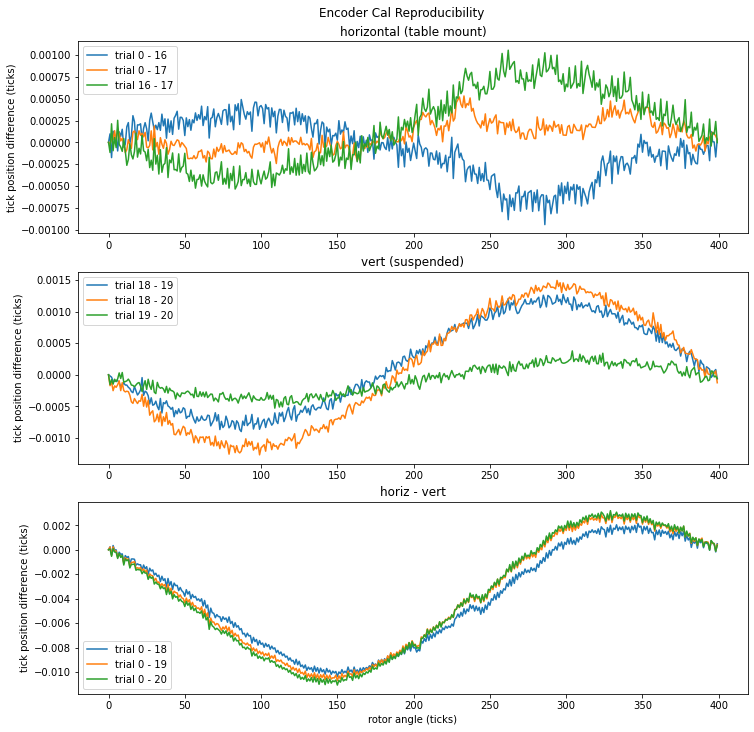

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(12,12))
ax[0].plot(calTicks_0 - calTicks_16, label='trial 0 - 16')
ax[0].plot(calTicks_0 - calTicks_17, label='trial 0 - 17')
ax[0].plot(calTicks_16 - calTicks_17, label='trial 16 - 17')
ax[0].legend()
ax[0].set_ylabel('tick position difference (ticks)')
ax[0].set_title('horizontal (table mount)')

ax[1].plot(calTicks_18 - calTicks_19, label='trial 18 - 19')
ax[1].plot(calTicks_18 - calTicks_20, label='trial 18 - 20')
ax[1].plot(calTicks_19 - calTicks_20, label='trial 19 - 20')
ax[1].legend()
ax[1].set_ylabel('tick position difference (ticks)')
ax[1].set_title('vert (suspended)')

ax[2].plot(calTicks_0 - calTicks_18, label='trial 0 - 18')
ax[2].plot(calTicks_0 - calTicks_19, label='trial 0 - 19')
ax[2].plot(calTicks_0 - calTicks_20, label='trial 0 - 20')
ax[2].legend()
ax[2].set_xlabel('rotor angle (ticks)')
ax[2].set_ylabel('tick position difference (ticks)')
ax[2].set_title('horiz - vert')

fig.suptitle('Encoder Cal Reproducibility', y=0.92)

rotor offset = 18
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[269 270 271 ... 266 267 268]
[269.07395576 270.0874459  271.13546125 ... 266.0854133  267.13182369
 268.08349177]
The RMS tick error of the uncalibrated tick positions is: 0.057984 ticks
The RMS tick error of the calibrated tick positions is: 0.000400 ticks


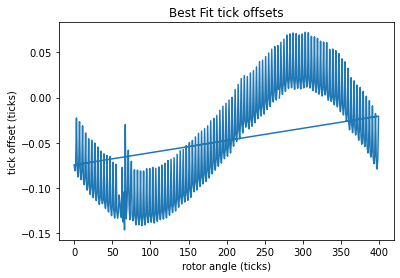

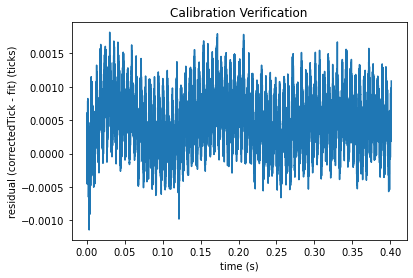

In [20]:
fname = 'encoderCal_20460001_80Hz_CalBlade_index=66_offset=18.txt'
calTicks_18 = DoSpinDownCal((file_dir/fname), 18)

rotor offset = 330
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[220 221 222 ... 217 218 219]
[220.    220.99  222.001 ... 216.989 217.999 219.052]
The RMS tick error of the uncalibrated tick positions is: 0.057081 ticks
The RMS tick error of the calibrated tick positions is: 0.000329 ticks


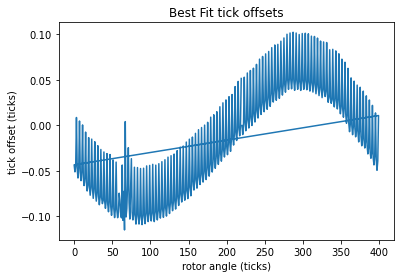

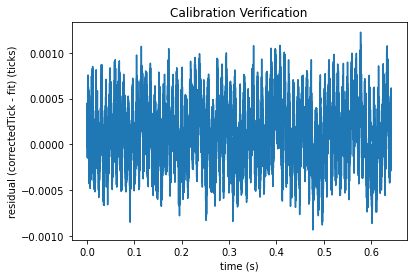

In [298]:
fname = 'encoderCal_20460001_50Hz_CalBlade_index=66_offset=330.txt'
calTicks_330 = DoSpinDownCal((file_dir/fname), 330)

rotor offset = 242
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[148 149 150 ... 145 146 147]
[148.    148.993 150.007 ... 144.992 146.004 147.055]
The RMS tick error of the uncalibrated tick positions is: 0.061198 ticks
The RMS tick error of the calibrated tick positions is: 0.000313 ticks


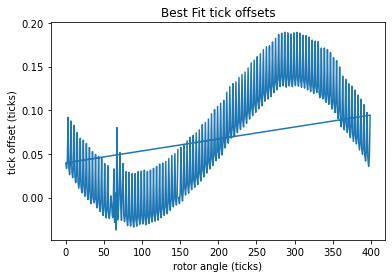

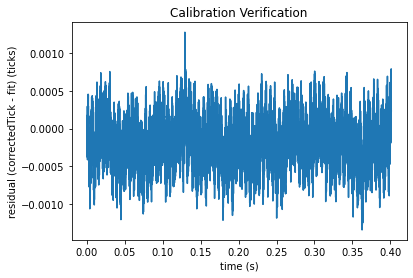

In [299]:
fname = 'encoderCal_20460001_80Hz_CalBlade_index=66_offset=242_horiz.txt'
calTicks_242 = DoSpinDownCal((file_dir/fname), 242)

rotor offset = 251
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[157 158 159 ... 154 155 156]
[157.    157.993 159.007 ... 153.992 155.004 156.055]
The RMS tick error of the uncalibrated tick positions is: 0.061198 ticks
The RMS tick error of the calibrated tick positions is: 0.000313 ticks


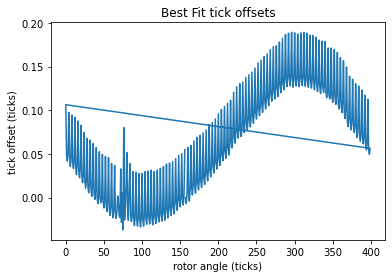

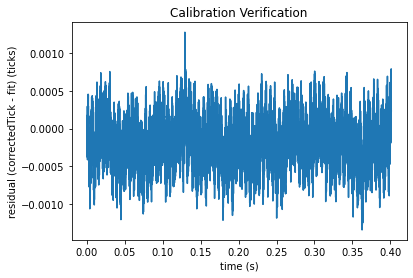

In [300]:
fname = 'encoderCal_20460001_80Hz_CalBlade_index=66_offset=251_horiz.txt'
calTicks_251 = DoSpinDownCal((file_dir/fname), 251)

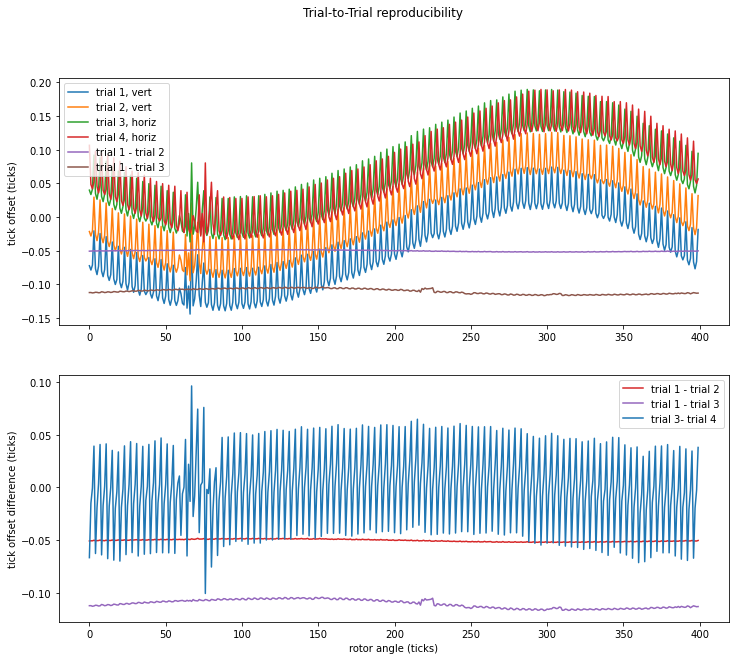

In [302]:
fig, ax = plt.subplots(2, 1, figsize=(12,10))
ax[0].plot(calTicks_18 - np.arange(0, 400, 1), label='trial 1, vert')
ax[0].plot(calTicks_321 - np.arange(0, 400, 1), label='trial 2, vert')
ax[0].plot(calTicks_242 - np.arange(0, 400, 1), label='trial 3, horiz')
ax[0].plot(calTicks_251 - np.arange(0, 400, 1), label='trial 4, horiz')
ax[0].plot(calTicks_18 - calTicks_321, label='trial 1 - trial 2')
ax[0].plot(calTicks_18 - calTicks_242, label='trial 1 - trial 3')
#ax[0].plot(calTicks_242 - calTicks_251, label='trial 3 - trial 4')

ax[1].plot(calTicks_18 - calTicks_321, label='trial 1 - trial 2', color='C3')
ax[1].plot(calTicks_18 - calTicks_242, label='trial 1 - trial 3', color='C4')
ax[1].plot(calTicks_242 - calTicks_251, label='trial 3- trial 4')
fig.suptitle('Trial-to-Trial reproducibility')

ax[0].set_ylabel('tick offset (ticks)')
ax[0].legend()
ax[1].set_xlabel('rotor angle (ticks)')
ax[1].set_ylabel('tick offset difference (ticks)')
ax[1].legend()


In [101]:
#file_dir = '.\CalData\Repeatability Tests'
file_dir = '.\CalData\Repeatability Tests'
files = glob(os.path.join(file_dir, '*.txt'))
files.sort(key=os.path.getmtime)
files

['.\\CalData\\Repeatability Tests\\encoderCal_20460001_0.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_1.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_2.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_3.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_4.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_5.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_6.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_7.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_8.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_9.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_10.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_11.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_12.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_13.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_20460001_14.txt',
 '.\\CalData\\Repeatability Tests\\encoderCal_2046

Chopper Head serial number: 20460001
rotor offset = 164
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[19 20 21 ... 16 17 18]
[18.99061235 19.98111661 20.99354633 ... 15.98403222 16.99444593
 18.04431815]
The RMS tick error of the uncalibrated tick positions is: 0.050996 ticks
The RMS tick error of the calibrated tick positions is: 0.000313 ticks
Chopper Head serial number: 20460001
rotor offset = 132
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[387 388 389 ... 384 385 386]
[387.01366705 388.00417131 389.01660103 ... 384.00708692 385.01750063
 386.06737285]
The RMS tick error of the uncalibrated tick positions is: 0.050996 ticks
The RMS tick error of the calibrated tick positions is: 0.000313 ticks
Chopper Head serial number: 20460001
rotor offset = 70
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[114 115 116 ... 111 112 113]
[114.01174633 114.95902507 115.95113805 ... 110.9575932  111.9498083
 112.9609068

<ipython-input-79-e1cff5dbbc5f>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots()
<ipython-input-79-e1cff5dbbc5f>:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, ax2 = plt.subplots()
<ipython-input-79-e1cff5dbbc5f>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(


[76 77 78 ... 73 74 75]
[75.95686598 76.96792797 78.01755872 ... 72.96758813 74.01760795
 74.96537522]
The RMS tick error of the uncalibrated tick positions is: 0.053924 ticks
The RMS tick error of the calibrated tick positions is: 0.000297 ticks
Chopper Head serial number: 20460001
rotor offset = 56
Importing 12800 rows (32 revs worth of data)
No missing or extra counts

<ipython-input-79-e1cff5dbbc5f>:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, ax2 = plt.subplots()
<ipython-input-79-e1cff5dbbc5f>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots()



[86 87 88 ... 83 84 85]
[86.0167937  86.96526587 87.95759126 ... 82.96399122 83.9559855
 84.96734438]
The RMS tick error of the uncalibrated tick positions is: 0.053678 ticks
The RMS tick error of the calibrated tick positions is: 0.000327 ticks
Chopper Head serial number: 20460001
rotor offset = 146
Importing 12800 rows (32 revs worth of data)
No missing or extra counts

<ipython-input-79-e1cff5dbbc5f>:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, ax2 = plt.subplots()
<ipython-input-79-e1cff5dbbc5f>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots()
<ipython-input-79-e1cff5dbbc5f>:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, ax2 = plt.subplots(


[245 246 247 ... 242 243 244]
[245.08392239 246.13343058 247.08297544 ... 242.13024568 243.08038101
 244.07123763]
The RMS tick error of the uncalibrated tick positions is: 0.053203 ticks
The RMS tick error of the calibrated tick positions is: 0.000304 ticks
Chopper Head serial number: 20460001
rotor offset = 147
Importing 12800 rows (32 revs worth of data)
No missing or extra counts


<ipython-input-79-e1cff5dbbc5f>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots()
<ipython-input-79-e1cff5dbbc5f>:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, ax2 = plt.subplots()
<ipython-input-79-e1cff5dbbc5f>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(

[396 397 398 ... 393 394 395]
[396.0077166  397.01399211 398.06649005 ... 393.03273331 394.08227117
 395.02818485]
The RMS tick error of the uncalibrated tick positions is: 0.184001 ticks
The RMS tick error of the calibrated tick positions is: 0.172719 ticks
Chopper Head serial number: 20460001
rotor offset = 290
Importing 12800 rows (32 revs worth of data)
No missing or extra counts
[248 249 250 ... 245 246 247]
[248.07406788 249.08624832 250.13625336 ... 245.08392311 246.13374085
 247.08252781]
The RMS tick error of the uncalibrated tick positions is: 0.054504 ticks
The RMS tick error of the calibrated tick positions is: 0.000303 ticks


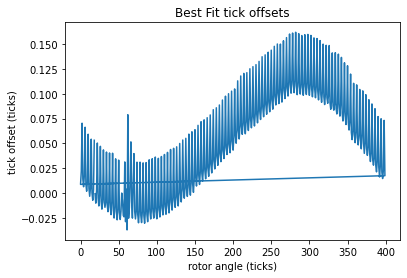

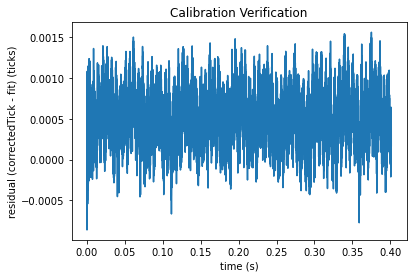

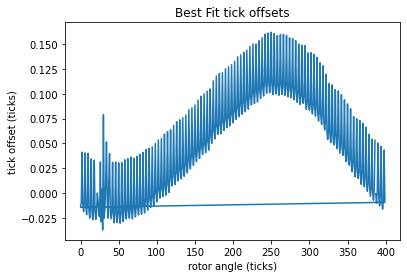

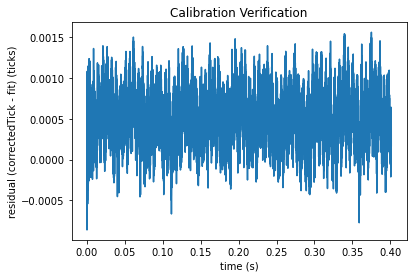

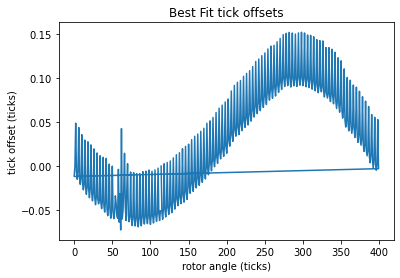

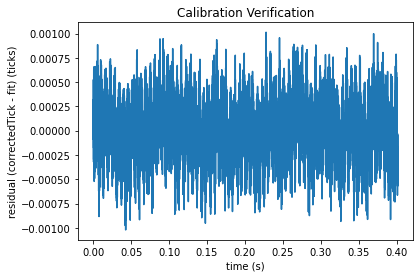

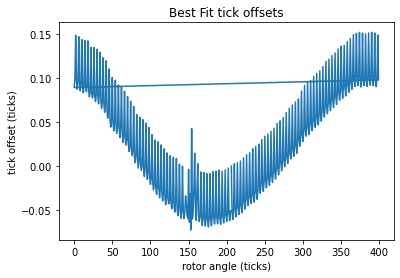

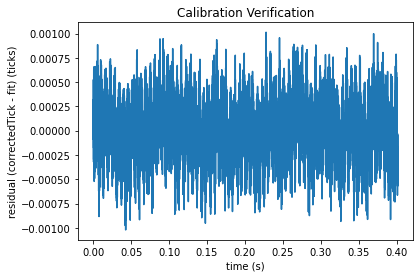

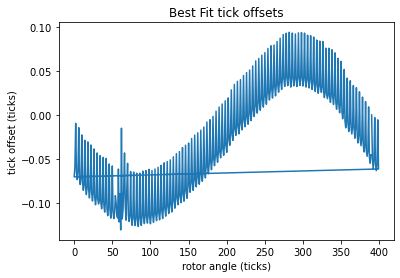

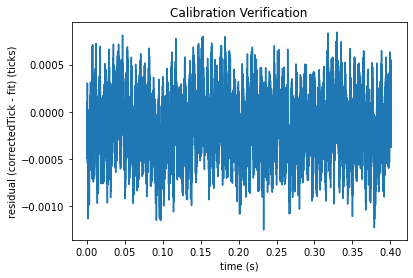

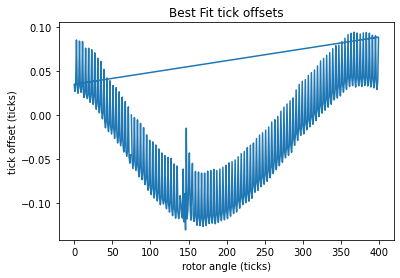

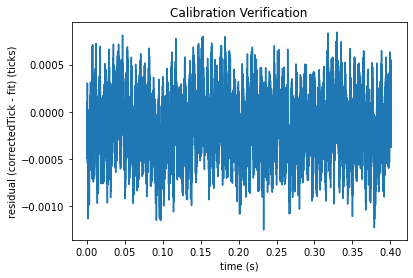

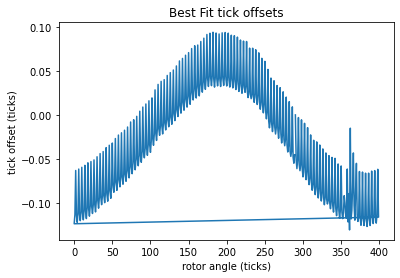

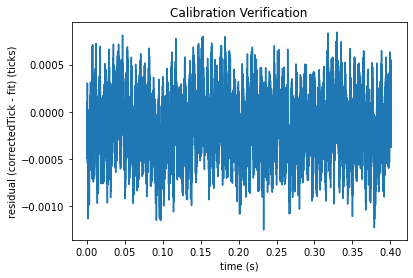

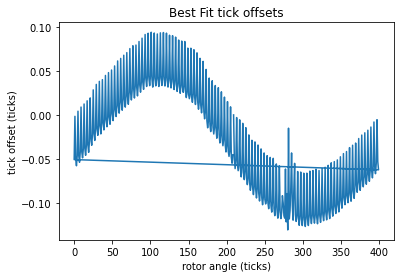

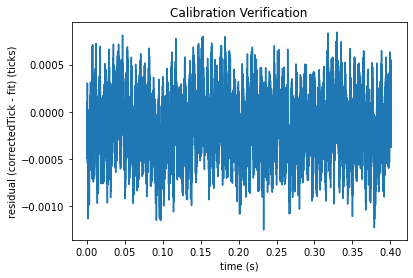

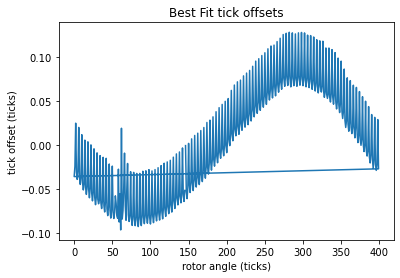

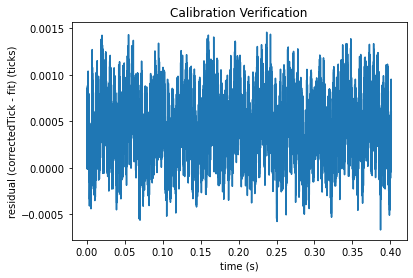

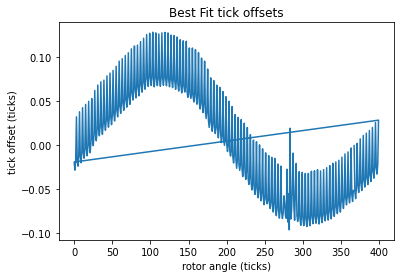

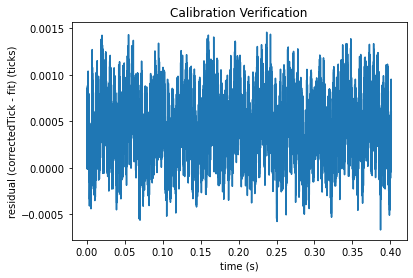

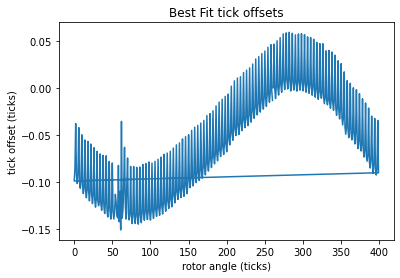

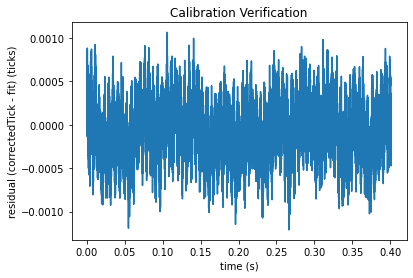

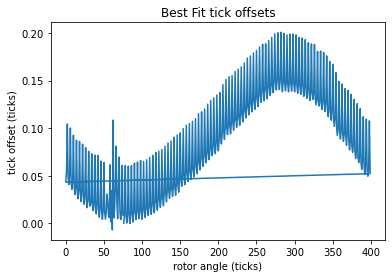

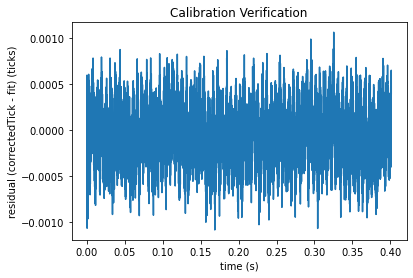

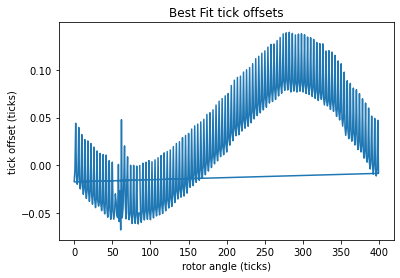

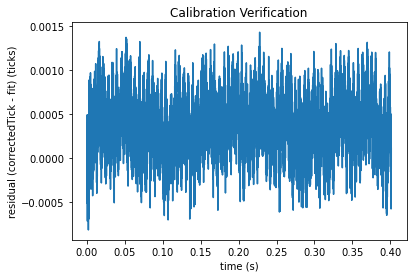

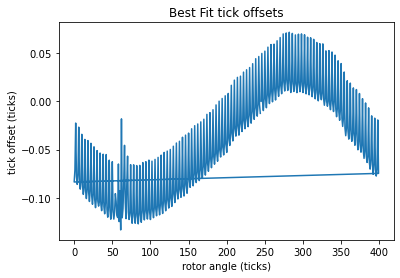

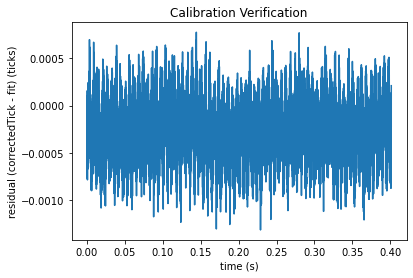

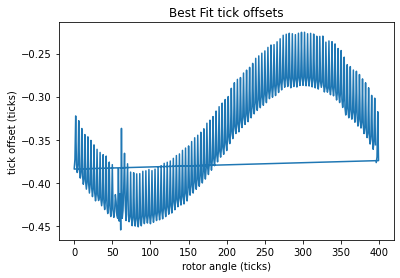

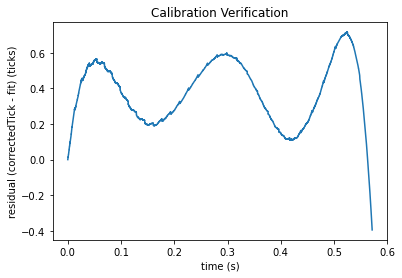

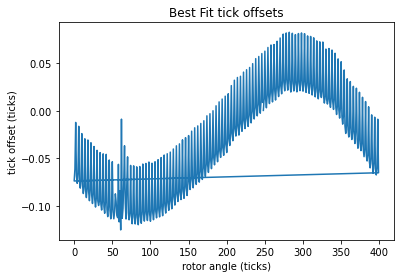

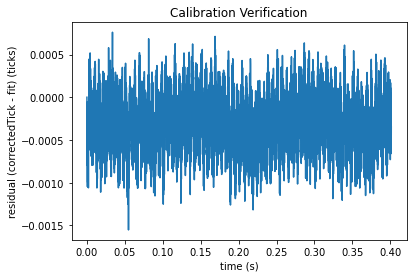

In [102]:
results = []
rotorOffsets = []
for file in files:
    f = open(file, 'r')
    sn = f.readline()
    shaftIndex = f.readline()
    rotorOffset = f.readline()
    f.close()    
    
    if(shaftIndex == '# shaft index = 61\n'):
        result = DoSpinDownCal(file)
        results.append(result)
        rotorOffsets.append(int(rotorOffset.strip('# rotor offset = ').strip()))

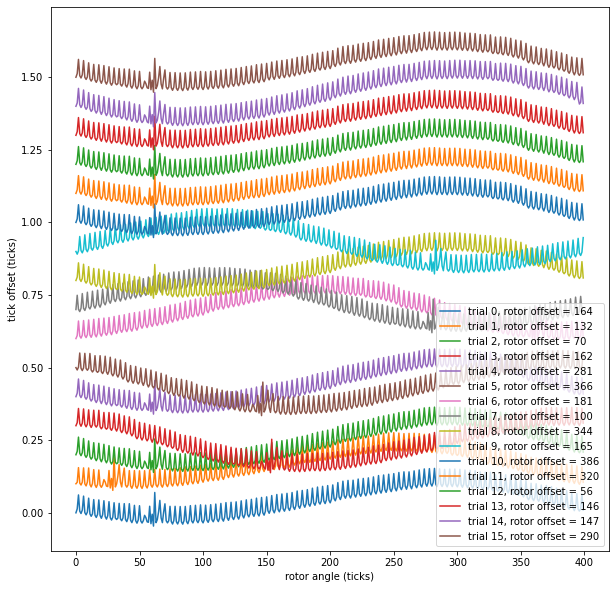

In [103]:
fig = plt.subplots(figsize=(10,10))
shift = 0.1
for i, result in enumerate(results):
    plt.plot(result - np.arange(0, 400, 1) + i*shift, label=f'trial {i}, rotor offset = {rotorOffsets[i]}')
    
plt.xlabel('rotor angle (ticks)')
plt.ylabel('tick offset (ticks)')
plt.legend(loc='lower right')

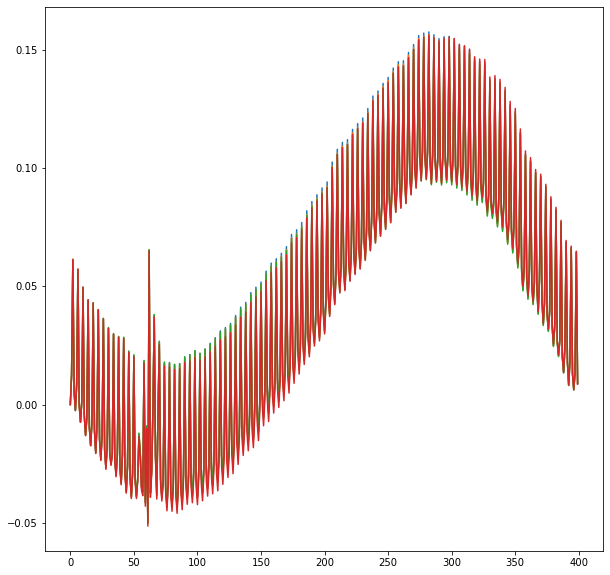

In [105]:
fig = plt.subplots(figsize=(10, 10))
plt.plot(results[11] - np.arange(0, 400, 1))
plt.plot(results[12] - np.arange(0, 400, 1))
plt.plot(results[13] - np.arange(0, 400, 1))
plt.plot(results[15] - np.arange(0, 400, 1))

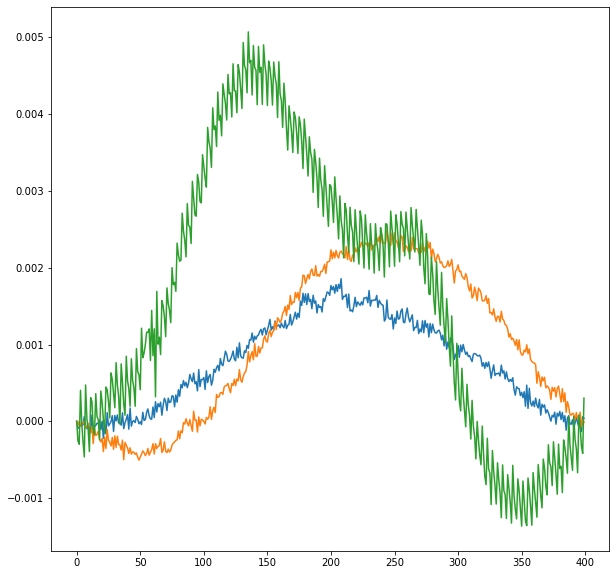

In [104]:
fig = plt.subplots(figsize=(10, 10))
plt.plot(results[11] - results[12])
plt.plot(results[11] - results[13])
plt.plot(results[11] - results[15])

In [94]:
sn

'# sn = 20460001\n'

In [95]:
sn = sn.strip('# sn = ').strip()
sn

'20460001'

In [96]:
file_dir

'.\\CalData\\Repeatability Tests'

In [99]:
np.savetxt(os.path.join('.\CalData', f'tickPos_{sn}.csv'), results[11]/400, newline='\n', fmt='%.6e', delimiter=',')

In [100]:
results[11][253]/400

0.632731337572244